In [1]:
import pyarrow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')

# Загрузка данных

In [2]:
train = pd.read_parquet('train.parquet')

In [3]:
train.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


# Проверка пропущенных значений

In [5]:
train.isnull().sum()

id        0
dates     0
values    0
label     0
dtype: int64

In [6]:
for index, row in train.iterrows():
    if len(row['dates']) != len(row['values']):
        print(row[id])

In [7]:
train = train.explode(['dates', 'values'])
train['dates'] = pd.to_datetime(train['dates'], format='%Y-%m-%d')

In [8]:
train.isna().sum()

id           0
dates        0
values    4582
label        0
dtype: int64

In [9]:
train[train.isna().any(axis=1)]

,id,dates,values,label
1979,95215,2016-03-01,NaN,1.0
1979,95215,2016-04-01,NaN,1.0
1979,95215,2016-05-01,NaN,1.0
1979,95215,2016-06-01,NaN,1.0
1979,95215,2016-07-01,NaN,1.0
...,...,...,...,...
78748,72302,2020-10-01,NaN,0.0
78748,72302,2020-11-01,NaN,0.0
78748,72302,2020-12-01,NaN,0.0
78748,72302,2021-01-01,NaN,0.0


In [10]:
nan_list = train[train.isna().any(axis=1)]['id'].unique()
train = pd.read_parquet('train.parquet')

# Распределение классов

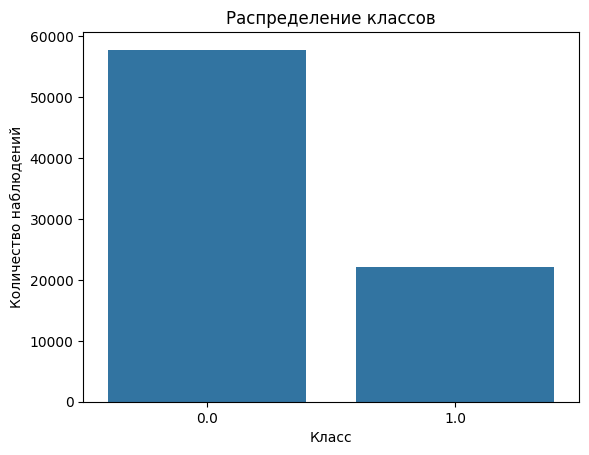

In [11]:
sns.countplot(x='label', data=train)
plt.xlabel('Класс')
plt.ylabel('Количество наблюдений')
plt.title('Распределение классов')
plt.show()

In [12]:
percent = round((train[train['label'] == 1]['label'].sum() / len(train)) * 100, 2)
print(f'Доля класса 1: {percent}%')

Доля класса 1: 27.72%


# Визуализация временных рядов

In [13]:
vis_train = train.explode(['dates', 'values'])

In [14]:
vis_train['dates'] = pd.to_datetime(vis_train['dates'], format='%Y-%m-%d')


In [15]:
vis_train = vis_train.reset_index().drop('index', axis=1)
vis_train

,id,dates,values,label
0,19114,2016-01-01,-1.86,0.0
1,19114,2016-02-01,0.79,0.0
2,19114,2016-03-01,1.4,0.0
3,19114,2016-04-01,0.15,0.0
4,19114,2016-05-01,0.0,0.0
...,...,...,...,...
5155407,98870,2019-11-01,1.40335,1.0
5155408,98870,2019-12-01,0.26335,1.0
5155409,98870,2020-01-01,-1.73665,1.0
5155410,98870,2020-02-01,-0.38665,1.0


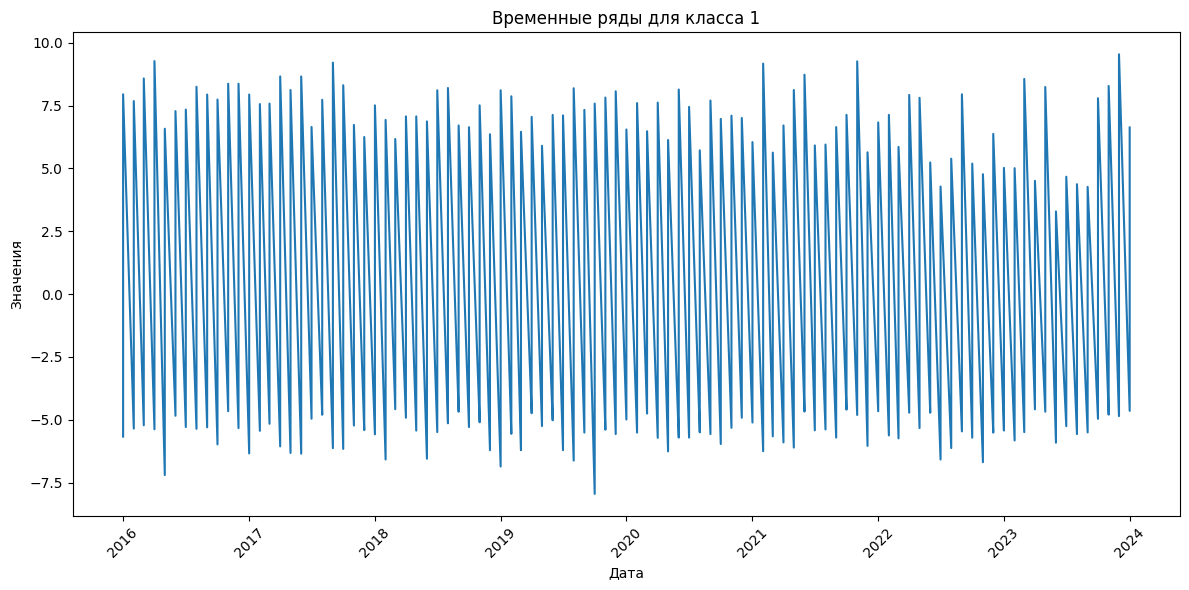

In [16]:
plt.figure(figsize=(12, 6))
class_data = vis_train[vis_train['label'] == 1]
sns.lineplot(data=class_data, x='dates', y='values', estimator=None, ci=None)
plt.title('Временные ряды для класса 1')
plt.xlabel('Дата')
plt.ylabel('Значения')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

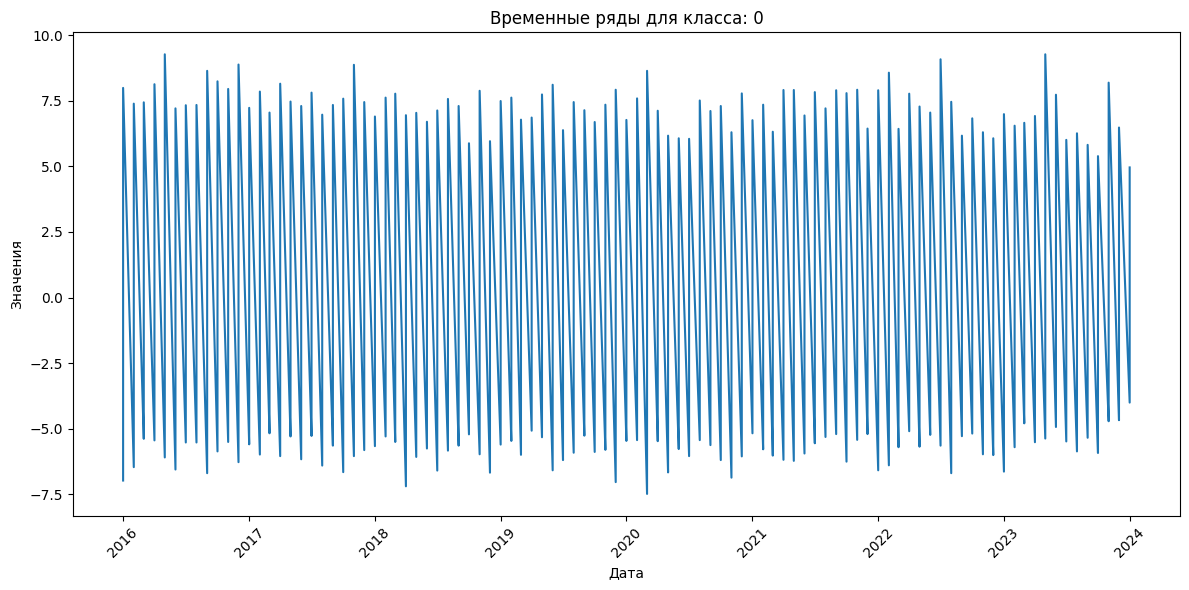

In [17]:
plt.figure(figsize=(12, 6))
class_data = vis_train[vis_train['label'] == 0]
sns.lineplot(data=class_data, x='dates', y='values', estimator=None, ci=None)
plt.title('Временные ряды для класса: 0')
plt.xlabel('Дата')
plt.ylabel('Значения')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Генерация признаков

In [18]:
def generate_val_features(df):
    values_array = np.array(df['values'].tolist(), dtype=object)

    return pd.DataFrame({
        'id': df['id'],
        'val_mean': [np.mean(val) for val in values_array],
        'val_std': [np.std(val) for val in values_array],
        'val_max': [np.max(val) for val in values_array],
        'val_min': [np.min(val) for val in values_array],
        'val_median': [np.median(val) for val in values_array],
        'val_25%': [np.percentile(val, 25) for val in values_array],
        'val_75%': [np.percentile(val, 75) for val in values_array],
    })

In [19]:
train = train.merge(generate_val_features(train), on='id', how='left')

In [20]:
for feature in ['val_mean', 'val_std', 'val_max', 'val_min', 'val_median', 'val_25%', 'val_75%']:
    train[feature].fillna(train[feature].mean(), inplace=True)

In [21]:
train = train.explode(['dates', 'values'])
train['dates'] = pd.to_datetime(train['dates'], format='%Y-%m-%d')

In [22]:
train['year'] = train['dates'].dt.year

In [23]:
min_max_year = train.groupby('id').agg(min_date=('dates', 'min'), 
                                         max_date=('dates', 'max'), 
                                         min_year=('year', 'min'), 
                                         max_year=('year', 'max')).reset_index()

In [24]:
train = train.merge(min_max_year, on='id', how='left')

In [25]:
train['date_diff'] = train['max_date'].dt.to_period('M').view(dtype='int64') - train['min_date'].dt.to_period('M').view(dtype='int64')
train.head()

,id,dates,values,label,val_mean,val_std,val_max,val_min,val_median,val_25%,val_75%,year,min_date,max_date,min_year,max_year,date_diff
0,19114,2016-01-01,-1.86,0.0,0.02371,1.337272,3.49,-4.84,-0.11,-0.6825,0.77,2016,2016-01-01,2021-02-01,2016,2021,61
1,19114,2016-02-01,0.79,0.0,0.02371,1.337272,3.49,-4.84,-0.11,-0.6825,0.77,2016,2016-01-01,2021-02-01,2016,2021,61
2,19114,2016-03-01,1.4,0.0,0.02371,1.337272,3.49,-4.84,-0.11,-0.6825,0.77,2016,2016-01-01,2021-02-01,2016,2021,61
3,19114,2016-04-01,0.15,0.0,0.02371,1.337272,3.49,-4.84,-0.11,-0.6825,0.77,2016,2016-01-01,2021-02-01,2016,2021,61
4,19114,2016-05-01,0.0,0.0,0.02371,1.337272,3.49,-4.84,-0.11,-0.6825,0.77,2016,2016-01-01,2021-02-01,2016,2021,61


In [26]:
train = train.drop(columns=['dates', 'values', 'year', 'min_date', 'max_date'])
train = train.drop_duplicates().reset_index().drop('index', axis=1)

In [27]:
train.head()

,id,label,val_mean,val_std,val_max,val_min,val_median,val_25%,val_75%,min_year,max_year,date_diff
0,19114,0.0,0.023710,1.337272,3.49,-4.840000,-0.110000,-0.6825,0.7700,2016,2021,61
1,22769,1.0,-0.310777,1.556337,2.92,-3.534409,-0.274409,-1.0400,0.7100,2016,2020,44
2,76935,0.0,-0.046042,1.065023,2.61,-1.950000,-0.145000,-0.8775,0.6150,2017,2021,47
3,66297,0.0,-0.130000,1.158201,2.49,-2.220000,-0.345000,-0.9500,0.8250,2016,2019,47
4,2191,0.0,-0.270536,1.270529,2.87,-2.500000,-0.475000,-1.2500,0.6775,2016,2020,55


In [28]:
X = train.drop(['label', 'id'], axis=1)
y = train['label']

# Разделение на выборки

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Обучение модели и оценка модели

In [30]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [31]:
y_val_pred = model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_pred)
print(f'ROC AUC на обучающей выборке: {roc_auc:.4f}')

ROC AUC на обучающей выборке: 0.8205


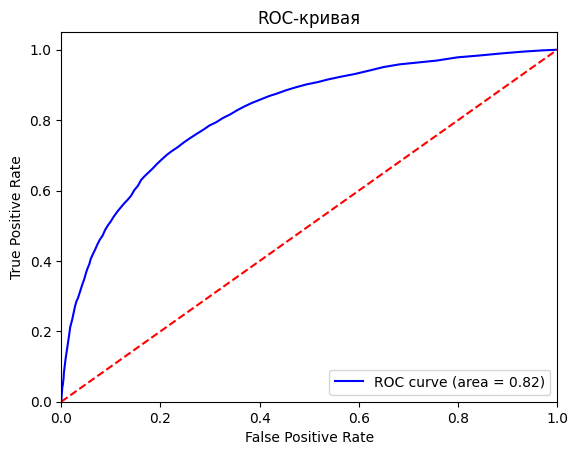

In [32]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

In [33]:
scores = cross_val_score(model, X, y, cv=5)
print("Баллы кросс-валидации:", scores)
print("Средний балл:", scores.mean())

Баллы кросс-валидации: [0.799     0.793375  0.793875  0.793625  0.7889375]
Средний балл: 0.7937624999999999


In [34]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)